In [1]:
import os
import sys
import cv2
import random
import numpy as np
import pandas as pd
import seaborn as sns
import multiprocessing as mp
import matplotlib.pyplot as plt
from tqdm import tqdm
from netCDF4 import Dataset
from functools import partial
from collections import defaultdict
from datetime import timedelta, date

In [6]:
cwd = os.getcwd()
data_directory = open('path_to_data.txt').read()
print(cwd, '\n', data_directory)

/home/sarthakj/code/AI/projects/summers/summer_2024/AFRL/env_pred/preprocessing 
 /home/sarthakj/data/MultiEarth/multiearth2023-dataset-final/data


### netCDF date interpreter Function

In [3]:
def date_from_date_delta(n, date='2018-12-13'):
    date = pd.to_datetime(date)
    return (date + timedelta(days=int(n))).strftime('%Y-%m-%d')

def delta_from_date_date(date, date0='2018-12-13'):
    date0 = pd.to_datetime(date0)
    date = pd.to_datetime(date)
    return (date - date0).days

### NP Array Metadata Function

In [4]:
def np_metadata(arr, name='Array', print_unique_values=False, print_unique_counts=False):
    print()
    print('Name:', name)
    print('\tShape:', arr.shape)
    print('\tSize:', arr.size)
    print('\tDimensions:', arr.ndim)
    print('\tDtype:', arr.dtype)
    print('\tMemory Usage:', arr.nbytes, 'bytes')
    print('\tNum Unique Values:', np.unique(arr).size)
    if '<U' not in str(arr.dtype):
        print('\tMIN:', arr.min())
        print('\tMAX:', arr.max())
    if print_unique_counts:
        print("(Value, Count): ", end='')
        for value, count in zip(*np.unique(arr, return_counts=True)):
            print(f'({value}, {count})', end=' ')
    elif print_unique_values:
        print('\tUnique Values:', np.unique(arr))
    print('\tPreview:', arr[:10])
    print()

def np_metadata_image(image, name='Image', print_unique_values=False):
    print()
    print('Name:', name)
    print('\tShape:', image.shape)
    print('\tSize:', image.size)
    print('\tDimensions:', image.ndim)
    print('\tDtype:', image.dtype)
    print('\tMemory Usage:', image.nbytes, 'bytes')
    print('\tMIN:', image.min())
    print('\tMAX:', image.max())
    print('\tNum Unique Values:', np.unique(image).size)
    if print_unique_values:
        print('\tUnique Values:', np.unique(image))
    '''
    print('\tPreview:')
    plt.imshow(image)
    plt.axis('off')
    plt.show()
    '''
    print()

# Combine Data

In [7]:
Original_sent2 = Dataset(os.path.join(data_directory, 'sent2_b1-b4_train.nc'))
Additional_sent2 = Dataset(os.path.join(data_directory, 'sent2_deforestation_segmentation.nc'))

# Coordinates
Original_COORDS = np.array(Original_sent2.variables['center_lat_lons']).T
Additional_COORDS = np.array(Additional_sent2.variables['center_lat_lons']).T
COORDS = np.concatenate((Original_COORDS, Additional_COORDS), axis=1)
np_metadata(COORDS, 'Coordinates')

# Dates
Original_DATES = np.array(Original_sent2.variables['collection_dates'])
Additional_DATES = np.array(Additional_sent2.variables['collection_dates'])
Combined_DATES_ARR = np.concatenate((Original_DATES, Additional_DATES), axis=0)
DATES = []
num_processes = mp.cpu_count()
print('Number of Processes:', num_processes)
pool = mp.Pool(processes=num_processes)
args = [(str(NUM)) for NUM in Combined_DATES_ARR]
partial_date_from_date_delta = partial(date_from_date_delta, date='2018-12-13')
for outputs in tqdm(pool.imap(partial_date_from_date_delta, args), total=len(args)):
    DATES.append(outputs)
    pass
pool.close()
pool.join()
DATES = np.array(DATES)
np_metadata(DATES, 'Dates')

# Data Bands
Original_DATA_BANDS = np.array(Original_sent2.variables['data_band'])
Additional_DATA_BANDS = np.array(Additional_sent2.variables['data_band'])
Additional_DATA_BANDS_DICT = {Additional_DATA_BANDS[i] : i for i in range(Additional_DATA_BANDS.shape[0])}
DATA_BANDS = Original_DATA_BANDS

# Images
def get_image(idx):
    Original_num_images = Original_sent2.variables['images'].shape[0]
    Additional_num_images = Additional_sent2.variables['images'].shape[0]
    if idx < Original_num_images:
        return np.array(Original_sent2.variables['images'][idx])
    else:
        idx -= Original_num_images
        img = np.array(Additional_sent2.variables['images'][idx])
        img = img[[Additional_DATA_BANDS_DICT[band] for band in DATA_BANDS]]
        return img


Name: Coordinates
	Shape: (2, 427813)
	Size: 855626
	Dimensions: 2
	Dtype: float64
	Memory Usage: 6845008 bytes
	Num Unique Values: 88
	MIN: -55.2
	MAX: -3.33
	Preview: [[ -4.39  -4.39  -4.39 ...  -3.87  -3.87  -3.87]
 [-55.2  -55.2  -55.2  ... -54.8  -54.8  -54.8 ]]

Number of Processes: 12


100%|██████████| 427813/427813 [00:18<00:00, 23253.98it/s]



Name: Dates
	Shape: (427813,)
	Size: 427813
	Dimensions: 1
	Dtype: <U10
	Memory Usage: 17112520 bytes
	Num Unique Values: 441
	Preview: ['2018-12-13' '2018-12-18' '2018-12-23' '2018-12-28' '2019-01-02'
 '2019-01-07' '2019-01-12' '2019-01-17' '2019-01-22' '2019-01-27']



# Analyze Valid Data

## Helpful Functions

In [8]:
# Images
def get_image(idx):
    Original_num_images = Original_sent2.variables['images'].shape[0]
    Additional_num_images = Additional_sent2.variables['images'].shape[0]
    if idx < Original_num_images:
        return np.array(Original_sent2.variables['images'][idx])
    else:
        idx -= Original_num_images
        img = np.array(Additional_sent2.variables['images'][idx])
        img = img[[Additional_DATA_BANDS_DICT[band] for band in DATA_BANDS]]
        return img
    
def normalize_image(image):
    percentile = np.percentile(image, [5, 95])
    image = np.clip(image, percentile[0], percentile[1])
    image = (image - percentile[0]) / (percentile[1] - percentile[0])
    return image

## Valid Metadata

### Organize Data


Name: Valid Image Indexes
	Shape: (79749,)
	Size: 79749
	Dimensions: 1
	Dtype: int64
	Memory Usage: 637992 bytes
	Num Unique Values: 79749
	MIN: 1
	MAX: 427797
	Preview: [ 1  3 18 36 40 41 42 43 45 46]


Name: Coordinates
	Shape: (79749, 2)
	Size: 159498
	Dimensions: 2
	Dtype: float64
	Memory Usage: 1275984 bytes
	Num Unique Values: 88
	MIN: -55.2
	MAX: -3.33
	Preview: [[ -4.39 -55.2 ]
 [ -4.39 -55.2 ]
 [ -4.39 -55.2 ]
 [ -4.39 -55.2 ]
 [ -4.39 -55.2 ]
 [ -4.39 -55.2 ]
 [ -4.39 -55.2 ]
 [ -4.39 -55.2 ]
 [ -4.39 -55.2 ]
 [ -4.39 -55.2 ]]


Name: Dates
	Shape: (79749,)
	Size: 79749
	Dimensions: 1
	Dtype: <U10
	Memory Usage: 3189960 bytes
	Num Unique Values: 334
	Preview: ['2018-12-18' '2018-12-28' '2019-03-13' '2019-06-11' '2019-07-01'
 '2019-07-06' '2019-07-11' '2019-07-16' '2019-07-26' '2019-07-31']


Name: Diffs
	Shape: (78048,)
	Size: 78048
	Dimensions: 1
	Dtype: int64
	Memory Usage: 624384 bytes
	Num Unique Values: 144
	MIN: 2
	MAX: 485
(Value, Count): (2, 3598) (3, 3671) (5, 27586

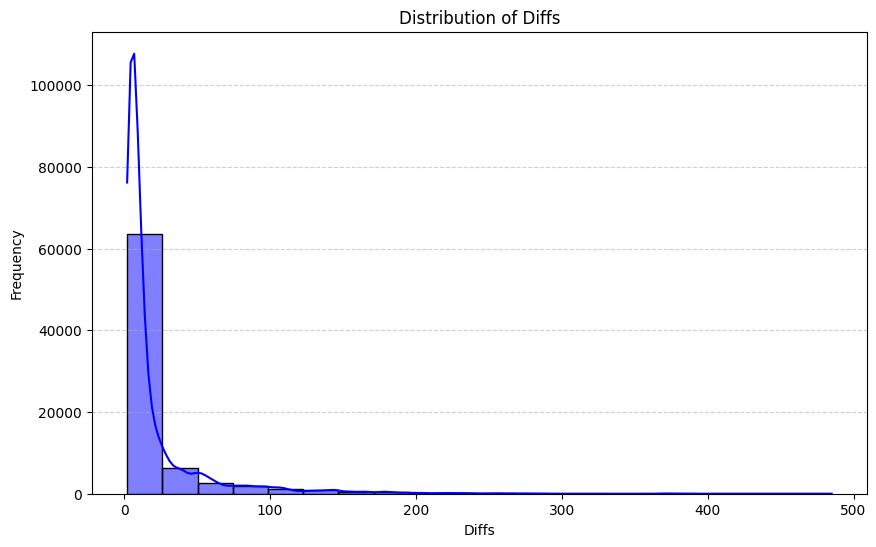

In [9]:
# Get Valid Images Indexes
valid_image_indexes = np.load('sent2_valid_image_index.npy')
np_metadata(valid_image_indexes, 'Valid Image Indexes')

# Retrieve Metadata: COORDS, DATES, IMAGES
if COORDS.shape[0] == 2: COORDS = COORDS.T
if not COORDS.shape[0] == valid_image_indexes.shape[0]: COORDS = COORDS[valid_image_indexes]
if not DATES.shape[0] == valid_image_indexes.shape[0]: DATES = DATES[valid_image_indexes]
np_metadata(COORDS, 'Coordinates')
np_metadata(DATES, 'Dates')

DATES_NUM = [delta_from_date_date(date, date0='2018-12-13') for date in DATES]
COORD_DATE_DICT = defaultdict(list)
COORD_DATE_INDEX_DICT = {}
for i in range(len(COORDS)):
    COORD_DATE_DICT[tuple(COORDS[i])].append(DATES_NUM[i])
    COORD_DATE_INDEX_DICT[(tuple(COORDS[i]), DATES_NUM[i])] = valid_image_indexes[i]
diffs = []
DIFFS_TO_PAIRS = defaultdict(list)
for key in COORD_DATE_DICT.keys():
    dates = COORD_DATE_DICT[key]
    dates = sorted(dates)
    for i in range(1, len(dates)):
        diffs.append(dates[i] - dates[i-1])
        DIFFS_TO_PAIRS[dates[i] - dates[i-1]].append((COORD_DATE_INDEX_DICT[(key, dates[i-1])], COORD_DATE_INDEX_DICT[(key, dates[i])]))
diffs = np.array(diffs)
np_metadata(diffs, 'Diffs', True, True)

# plot distribution of diffs
plt.figure(figsize=(10, 6))
sns.histplot(diffs, bins=20, kde=True, color='blue')
plt.title('Distribution of Diffs')
plt.xlabel('Diffs')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

### Find Distribution of Frequencies for each Month


Name: Year-Month Frequency
	Shape: (37,)
	Size: 37
	Dimensions: 1
	Dtype: int64
	Memory Usage: 296 bytes
	Num Unique Values: 37
	MIN: 65
	MAX: 9361
(Value, Count): (65, 1) (84, 1) (122, 1) (241, 1) (254, 1) (298, 1) (349, 1) (355, 1) (370, 1) (372, 1) (465, 1) (482, 1) (516, 1) (628, 1) (680, 1) (771, 1) (783, 1) (837, 1) (895, 1) (1031, 1) (1045, 1) (1224, 1) (1502, 1) (1811, 1) (1895, 1) (2039, 1) (2328, 1) (3167, 1) (4257, 1) (4473, 1) (4926, 1) (4961, 1) (5491, 1) (5947, 1) (6736, 1) (8988, 1) (9361, 1) 	Preview: [ 65  84 122 241 254 298 349 355 370 372]



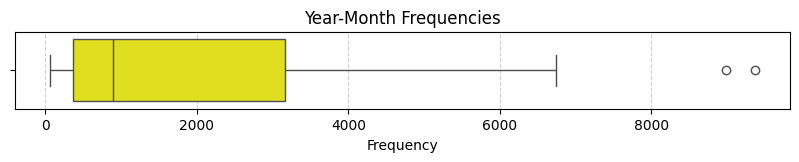

In [10]:
DATE_YEAR_MONTH_DICT = defaultdict(int)
for date in DATES:
    DATE_YEAR_MONTH_DICT[date[:7]] += 1
values = np.array(sorted(list(DATE_YEAR_MONTH_DICT.values())))
np_metadata(values, 'Year-Month Frequency', True, True)

# plot distribution of dates on a horizontal boxplot
plt.figure(figsize=(10, 1))
sns.boxplot(x=values, color='yellow')
plt.title('Year-Month Frequencies')
plt.xlabel('Frequency')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()

# Look into Coordinate Distribution

(79749, 2)
(79749,)
Number of Unique Locations: 1701

Name: Location Totals
	Shape: (1701,)
	Size: 1701
	Dimensions: 1
	Dtype: int64
	Memory Usage: 13608 bytes
	Num Unique Values: 81
	MIN: 3
	MAX: 112
(Value, Count): (3, 1) (4, 1) (5, 1) (21, 2) (22, 3) (24, 6) (25, 6) (26, 2) (27, 6) (28, 11) (29, 8) (30, 18) (31, 16) (32, 34) (33, 34) (34, 50) (35, 53) (36, 53) (37, 63) (38, 72) (39, 73) (40, 83) (41, 88) (42, 90) (43, 89) (44, 98) (45, 74) (46, 57) (47, 54) (48, 60) (49, 46) (50, 30) (51, 40) (52, 38) (53, 26) (54, 15) (55, 20) (56, 10) (57, 15) (58, 8) (59, 3) (60, 11) (61, 3) (62, 1) (63, 4) (64, 4) (65, 2) (66, 4) (67, 10) (68, 6) (69, 15) (70, 10) (71, 8) (72, 6) (73, 8) (74, 16) (75, 12) (76, 14) (77, 11) (78, 12) (79, 7) (80, 8) (81, 9) (82, 7) (83, 6) (84, 5) (85, 6) (86, 7) (87, 6) (88, 6) (89, 1) (91, 3) (92, 3) (93, 2) (94, 4) (95, 2) (98, 1) (101, 1) (106, 1) (109, 1) (112, 1) 	Preview: [43 41 40 39 39 44 41 34 39 36]



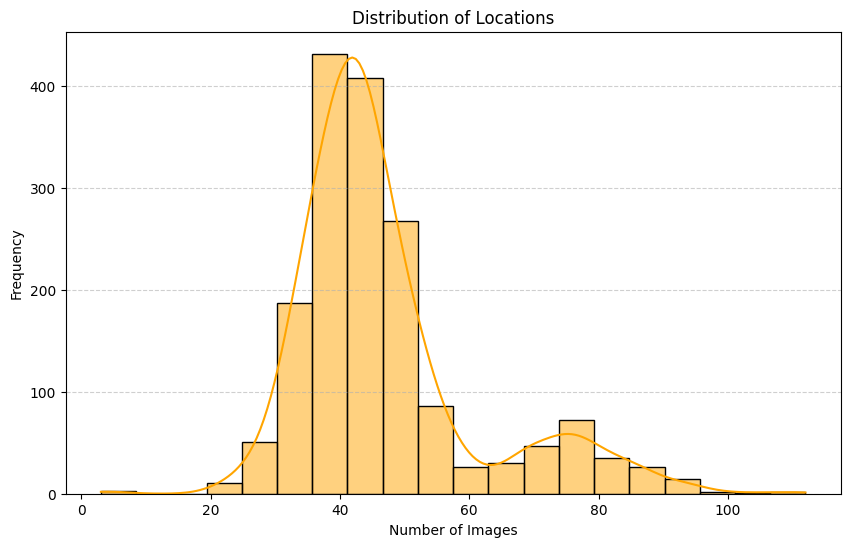

In [21]:
print(COORDS.shape)
DATES_NUM = np.array(DATES_NUM)
print(DATES_NUM.shape)

COORD_DICT = defaultdict(int)
for coord in COORDS:
    COORD_DICT[tuple(coord)] += 1
print('Number of Unique Locations:', len(COORD_DICT.keys()))
COORDINATE_TOTALS = np.array(list(COORD_DICT.values()))
np_metadata(COORDINATE_TOTALS, 'Location Totals', True, True)

# plot distribution of locations
plt.figure(figsize=(10, 6))
sns.histplot(COORDINATE_TOTALS, bins=20, kde=True, color='orange')
plt.title('Distribution of Locations')
plt.xlabel('Number of Images')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

# Split Data 90% Train 10% Test

In [35]:
# Split into 90% Train and 10% Test
# The Test Set should have at least 99% of locations
# The Test Set should have every date

num_data_points = valid_image_indexes.shape[0]
total_locations = len(COORD_DICT.keys())
total_dates = len(DATE_YEAR_MONTH_DICT.keys())
print('Total Number of Data Points:', num_data_points)

def split_train_test(num_data_points, test_size=0.1):
    test_size = int(num_data_points * test_size)
    test_indexes = np.random.choice(num_data_points, test_size, replace=False)
    train_indexes = np.array([idx for idx in valid_image_indexes if idx not in test_indexes])
    return train_indexes, test_indexes

def check_test_set_validity(test_indexes):
    test_coords = COORDS[test_indexes]
    test_coord_dict = defaultdict(int)
    for i in range(test_coords.shape[0]):
        test_coord_dict[tuple(test_coords[i])] += 1

    test_dates = DATES[test_indexes]
    test_dates_dict = defaultdict(int)
    for date in test_dates:
        test_dates_dict[date[:7]] += 1

    coordinate_percentage = 1.0 * len(test_coord_dict.keys()) / total_locations
    dates_percentage = 1.0 * len(test_dates_dict.keys()) / total_dates

    if len(test_coord_dict.keys()) < 0.99 * total_locations:
        return False, coordinate_percentage, dates_percentage
    if len(test_dates_dict.keys()) < total_dates:
        return False, coordinate_percentage, dates_percentage

    return True, coordinate_percentage, dates_percentage

def find_split(attempts = 10):
    idx = 0
    while idx < attempts:
        print()
        print("Attempt:", idx+1)
        train_indexes, test_indexes = split_train_test(num_data_points)
        works, coord_percentage, dates_percentage = check_test_set_validity(test_indexes) 
        print(f'Coordination Percentage: {coord_percentage * 100:.2f}%')
        print(f'Dates Percentage: {dates_percentage * 100:.2f}%')
        if works:
            return train_indexes, test_indexes
        idx += 1
        
train_indexes, test_indexes = find_split(attempts=20)
np_metadata(train_indexes, 'Train Indexes')
np_metadata(test_indexes, 'Test Indexes')

np.save('data_split/sent2_train_indexes.npy', train_indexes)
np.save('data_split/sent2_test_indexes.npy', test_indexes)

Total Number of Data Points: 79749

Attempt: 1
Coordination Percentage: 99.06%
Dates Percentage: 100.00%

Name: Train Indexes
	Shape: (78251,)
	Size: 78251
	Dimensions: 1
	Dtype: int64
	Memory Usage: 626008 bytes
	Num Unique Values: 78251
	MIN: 1
	MAX: 427797
	Preview: [ 1  3 18 36 40 41 42 43 45 48]


Name: Test Indexes
	Shape: (7974,)
	Size: 7974
	Dimensions: 1
	Dtype: int64
	Memory Usage: 63792 bytes
	Num Unique Values: 7974
	MIN: 4
	MAX: 79726
	Preview: [41046  8826  2748 73725 40341 10336  3244 71390 51806 24283]

